In [1]:
# %cd /home/jupyter/satlas_main/
# ! git clone https://github.com/allenai/satlas

In [2]:
non_cropped_input = "/home/jupyter/satlas_main/satlas_explorer_datasets/data/satlas_data_8_sentinel2_ms_stack_roi.npy"
cropped_filename = "cropped_image.npy"

In [3]:
!pip install rasterio

  Using cached rasterio-1.3.10-cp310-cp310-manylinux2014_x86_64.whl.metadata (14 kB)
  Using cached affine-2.4.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached cligj-0.7.2-py3-none-any.whl.metadata (5.0 kB)
  Using cached snuggs-1.4.7-py3-none-any.whl.metadata (3.4 kB)
  Using cached click_plugins-1.1.1-py2.py3-none-any.whl.metadata (6.4 kB)
Using cached rasterio-1.3.10-cp310-cp310-manylinux2014_x86_64.whl (21.5 MB)
Using cached cligj-0.7.2-py3-none-any.whl (7.1 kB)
Using cached snuggs-1.4.7-py3-none-any.whl (5.4 kB)
Using cached affine-2.4.0-py3-none-any.whl (15 kB)
Using cached click_plugins-1.1.1-py2.py3-none-any.whl (7.5 kB)


In [4]:
import rasterio
from rasterio.windows import Window
import numpy as np
import os
from IPython.display import display, Image

In [5]:
cropped_output = os.path.join(os.path.dirname(non_cropped_input), cropped_filename)
print(cropped_output)

/home/jupyter/satlas_main/satlas_explorer_datasets/data/cropped_image.npy


In [6]:
!pwd

/home/jupyter/satlas_main


In [7]:
image_stack = np.load(non_cropped_input)


num_images, num_bands, height, width = image_stack.shape
square_size = 1024

square_images = np.zeros((num_images, num_bands, square_size, square_size))

# Iterate over each image
for i in range(num_images):
    crop_height = (height - square_size) // 2
    crop_width = (width - square_size) // 2
    square_images[i] = image_stack[i, :, crop_height:crop_height+square_size, crop_width:crop_width+square_size]

new_square_images = np.array(square_images, dtype=image_stack.dtype)  # Use the same data type as input
print(new_square_images.shape)

(8, 9, 1024, 1024)


In [8]:
np.save(cropped_output, new_square_images)

In [9]:
image_stack = np.load(non_cropped_input)
print(image_stack.shape)
type(image_stack)


(8, 9, 1202, 1376)


numpy.ndarray

In [10]:
cropped_image = np.load(cropped_output)
print(cropped_image.shape)
type(cropped_image)

(8, 9, 1024, 1024)


numpy.ndarray

In [11]:
cropped_output
model_input = os.path.basename(cropped_output)


Got confing and device
aggregation backbone: underlying=resnet op=max image_channels=9 groups=[[0, 1, 2, 3, 4, 5, 6, 7]]
backbone_channels: [(1, 128), [4, 128], [8, 128], [16, 128], [32, 128]]
Model(
  (backbone): AggregationBackbone(
    (backbone): ResnetBackbone(
      (resnet): ResNet(
        (conv1): Conv2d(9, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, moment

100%|██████████| 1/1 [00:02<00:00,  2.28s/it]



Downloading:  cropped_image_rgb.png cropped_image.jpg


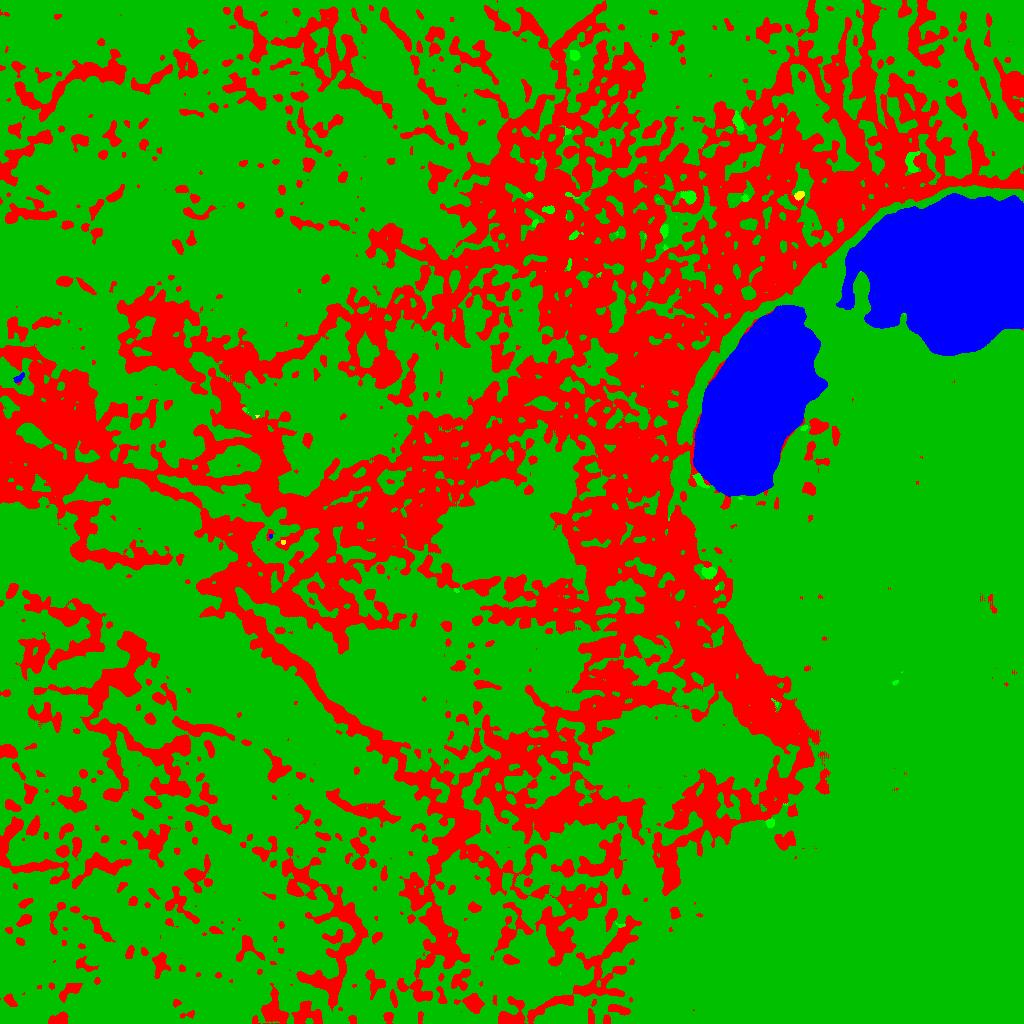

Image Saved


In [13]:
# SATLAS data and model preparstion steps

# perform inference
# https://github.com/allenai/satlas/blob/main/CustomInference.md#sentinel-2-inference-example

# download models
# https://huggingface.co/allenai/satlas-pretrain/tree/main/dataset

# preparation: ceate sentinel image , clone satlas, download models
# stack.npy created with the file preparedata.py

# put this file in the satlas directory, then run python3 inference.py

#----------------------------------------------------------------------------------------------------------
import os, glob
import zipfile
from pathlib import Path

datapath = "/home/jupyter/satlas_main/satlas_explorer_datasets/data/"
satlaspath = "/home/jupyter/satlas_main/"

config_path_base = satlaspath + "configs/"
model_path = satlaspath + "satlas_explorer_datasets/models/"

#-----------------------------------------------------------------------------------------------------------
import json
import numpy 
import skimage.io
import torch
import tqdm
import time
import satlas.model.evaluate
import satlas.model.model

# ---------------------------------------------------------------------------------------------------------
# Locations of model config and weights, and the input image.

# these combinations works ---------------------------------
#model = "sentinel2_swint_mi_ms.pth"
#config = "sentinel2/swint_mi_ms.txt"

model = "sentinel2_resnet152_mi_ms.pth"
config = "sentinel2/resnet152_mi_ms.txt"
# ----------------------------------------------------------

'''
RuntimeError: Error(s) in loading state_dict for Model: Missing key(s) in state_dict:
model = "sentinel2_resnet152_si_ms.pth"
config = "sentinel2/resnet152_mi_ms.txt"

model = "sentinel2_resnet50_mi_ms.pth"
config = "satlas_explorer_tree_cover.txt"
'''


image_npy = model_input

weights_path = model_path + model
config_path = config_path_base + config
image_path = datapath + image_npy

# Read config and initialize the model.
with open(config_path, 'r') as f:
    config = json.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for spec in config['Tasks']:
    if 'Task' not in spec:
        spec['Task'] = satlas.model.dataset.tasks[spec['Name']]

print("\nGot confing and device")
model = satlas.model.model.Model({'config': config['Model'],'channels': config['Channels'],'tasks': config['Tasks'],})
print("\nGot the model")
state_dict = torch.load(weights_path, map_location=device)
print("\nGot state_dict")
model.load_state_dict(state_dict)
print("\nModel loaded")
model.to(device)
print("\nModel to device")
print("trainable parameters", sum(p.numel() for p in model.parameters() if p.requires_grad))
print("\nEvaluating")
model.eval()

# image_path = r"/satlas_data_8_sentinel2_ms_stack_roi.npy"
image = numpy.load(image_path)
# For (N, C, H, W) image (with N timestamps), convert to (N*C, H, W).
image = image.reshape(image.shape[0]*image.shape[1], image.shape[2], image.shape[3])

# The image is large so apply it on windows.
# Here we collect outputs from head 0 which is the only head of the config (tree cover).
vis_output = numpy.zeros((image.shape[1], image.shape[2], 3), dtype=numpy.uint8)
crop_size = 1024
head_idx = 2

print("\nInference")
with torch.no_grad():
    for row in tqdm.tqdm(range(0, image.shape[1], crop_size)):
        for col in range(0, image.shape[2], crop_size):
            crop = image[:, row:row+crop_size, col:col+crop_size]
            vis_crop = crop.transpose(1, 2, 0)[:, :, 0:3]
            gpu_crop = torch.as_tensor(crop).to(device).float() / 255
            # print("passing crop section to the model..")
            outputs, _ = model([gpu_crop])
            vis_output_crop, _, _, _ = satlas.model.evaluate.visualize_outputs(
                task=config['Tasks'][head_idx]['Task'],
                image=vis_crop,
                outputs=outputs[head_idx][0],
                return_vis=True,)
        if len(vis_output_crop.shape) == 2:
            vis_output[row:row+crop_size, col:col+crop_size, 0] = vis_output_crop
            vis_output[row:row+crop_size, col:col+crop_size, 1] = vis_output_crop
            vis_output[row:row+crop_size, col:col+crop_size, 2] = vis_output_crop
        else:
            vis_output[row:row+crop_size, col:col+crop_size, :] = vis_output_crop


fimage_rgb =  image_npy.split('.npy')[0] + '_rgb.png'
fimage = image_npy.split('.npy')[0] + '.jpg'
try:
    print('\nDownloading: ', fimage_rgb, fimage)
    skimage.io.imsave(datapath + fimage_rgb, image[0:3, :, :].transpose(1, 2, 0))
    skimage.io.imsave(datapath + fimage, vis_output)
    # fimage = r"/home/jupyter/satlas_main/satlas_explorer_datasets/data/cropped_image.jpg"
    display(Image(filename=datapath + fimage))
    print("Image Saved")
except:
    print('\nError saving image results')
# --------------------------------------------------------------------------------------------